<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Sensitivity_Analysis_And_Method_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sensitivity Analysis and Method Comparison**

## **A. Identifying Variables for Primary Analysis Steps**
- **Y** (Binary CVD indicator variable - will be generated) The **hltprhc and hltphhc** that we have already identified
- **X** (Covariates) **agea, gndr, edulvlb, hinctnta cgtsmok, alcfreq, etfruit, eatveg, dosprt cntry imsmetn imdfetn impcntr polintr lrscale stflife**
Treatments (W) or Causal ML (ATE + HTE) goal to check it.


## **B. Identifying Variables for Sensitivity Checks**
  1. **Complete-Case vs. Imputed Analysis**:
     - To impute missing data, you need to identify variables with missingness. The code I supplied will try to drop the dataset.
     - Likely candidates with missing data (you'll need to check this in the actual dataset):
       - **hinctnta**: Household's total net income (Income questions are often sensitive).
       - **edulvlb**: Higher level of education.
       - Therefore this should be checked by:
First, to make new data with imputation values on variables to compare with that data.

  2. **Compare Causal Forest vs. TMLE vs. DML**: (This doesn't involve new variables, but requires implementing and comparing different ML models.)
  3. **Exclude Small-Sample Countries**:
     - Requires **cntry**: Country. You need to know the sample size per country and then filter the data accordingly. This isn't a variable used in the model, but rather used to subset the data.
     - This step reduces bias by reducing country effects that don't match each other, since not all parameters exist in each country.

  4. **Test Effect of Survey Weights**:
     - Requires weight variables (essential from the start):
        - **dweight**: Design weight
        - **pspwght**: Post-stratification weight including design weight
        - **pweight**: Population size weight (if appropriate – must combine with dweight or pspwght)
        - Compare results using CausalForestDML with and without these weights in the .fit() method.
  5. **Compute E-Value**: (Relies on having ATE point estimates and confidence intervals from your main model. E-value calculation does not involve more specific ESS variables.)



## **C. Creating Composite Variables or Performing Transformations**
Note, that it depends to the quality of result, but using that or not is depend on data and experience
  - **BMI**: Needs to be calculated.
     - Requires **weighta**: Weight of respondent (kg)
     - Requires **height**: Height of respondent (cm)
  - region: Need to create by your own, using "North, South, East, West" list by code (see before).


## **D. File Outputs**
 - **tables/sensitivity_summary.csv**: This CSV file will summarize the results of your sensitivity checks (ATE point estimates, CIs, E-values, etc.) for each robustness check performed.
 - **fig_sensitivity_plot.png**: A figure (likely a forest plot or similar) visualizing the range of ATE estimates across your sensitivity analyses.
Remember it for reports and keep it save


# **Installing Dependencies**

In [ ]:
!pip install econml

Reference: https://www.pywhy.org/EconML/_autosummary/econml.dml.CausalForestDML.html

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import CausalForestDML
from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression  # Import StatsModelsLinearRegression
from econml.dml import LinearDML, SparseLinearDML
from scipy.stats import norm


import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf  # Import for regression models and formulas
import os  # Import the os module

# **E-value Function**

In [ ]:
# E-value function (Rosenbaum sensitivity value)
def compute_e_value(ate, ate_lower, ate_upper):
    """Computes the E-value for a given ATE and confidence interval."""
    if ate > 0:
        risk_ratio = ate
        lower_ci = ate_lower
    else:
        risk_ratio = -ate
        lower_ci = ate_upper

    e_value = risk_ratio + np.sqrt(risk_ratio * (risk_ratio - 1))
    e_value_lower_ci = lower_ci + np.sqrt(lower_ci * (lower_ci - 1))
    return e_value, e_value_lower_ci


# **Load Dataset**

In [ ]:
# Load dataset
try:
    df = pd.read_csv('/content/ESS11.csv')
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check /content/ESS11.csv path.")

# Rename and basic checks
df = df.rename(columns={'hltprhc': 'CVD'})
print("Step 1: Renamed 'hltprhc' to 'CVD'")


Step 1: Renamed 'hltprhc' to 'CVD'


# **Data Cleaning & Required Cols**

In [ ]:
# Data cleaning & required cols
key_cols = ['weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt',
            'cgtsmok', 'alcfreq', 'edulvlb', 'hinctnta', 'cntry', 'dweight', 'pspwght']
# Check that required columns exist
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")

df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA in key columns. Remaining rows: {len(df)}")

Step 2: Dropped rows with NA in key columns. Remaining rows: 46162


In [ ]:
# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 10.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Calculated BMI and removed infinite values.")

Step 3: Calculated BMI and removed infinite values.


In [ ]:
# Ensure CVD is binary/int (map or cast if necessary)
if df['CVD'].dtype == object:
    # try simple mapping
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1','yes','true','y','t'] else 0)
    df['CVD'] = df['CVD'].astype(int)
print(f"Unique values in Y (CVD): {np.unique(df['CVD'])}")

Unique values in Y (CVD): [0 1]


# **Define X, T, Y**

In [ ]:
# Define X, T, Y
feature_cols = ['BMI', 'etfruit', 'eatveg', 'dosprt', 'cgtsmok',
                'alcfreq', 'edulvlb', 'hinctnta']
X = df[feature_cols].copy()
T = df['BMI'].copy()   # continuous treatment
Y = df['CVD'].copy()   # binary outcome (0/1)

# **European regions mapping**

In [ ]:
# European regions mapping
region_map = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East'
}

def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).upper()
    return region_map.get(c, 'Unknown')

df['region'] = df['cntry'].apply(get_region)  # Apply the mapping function to create the 'region' column
print("Step 2a: European region mapping.")

Step 2a: European region mapping.


# 1. **Complete-Case vs. Imputed Analyses**

In [ ]:
print("\n--- 1. Complete-Case vs. Imputed Analyses ---")
# a) Complete-Case Analysis (already done by dropping NAs earlier)
X_complete = X.copy()
Y_complete = Y.copy()
T_complete = T.copy()
print(f"Complete-case data size: X={X_complete.shape}, Y={Y_complete.shape}, T={T_complete.shape}")



--- 1. Complete-Case vs. Imputed Analyses ---
Complete-case data size: X=(46162, 8), Y=(46162,), T=(46162,)


In [ ]:
# b) Imputation Analysis
imputer = SimpleImputer(strategy='mean')  # Or 'median', 'most_frequent', 'constant'
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
Y_imputed = Y.copy()
T_imputed = T.copy()
print(f"Imputed data size: X={X_imputed.shape}, Y={Y_imputed.shape}, T={T_imputed.shape}")

Imputed data size: X=(46162, 8), Y=(46162,), T=(46162,)


# **Split Data**

In [ ]:
# Split data
X_train_complete, X_test_complete, Y_train_complete, Y_test_complete, T_train_complete, T_test_complete = train_test_split(
    X_complete, Y_complete, T_complete, test_size=0.2, random_state=42
)

X_train_imputed, X_test_imputed, Y_train_imputed, Y_test_imputed, T_train_imputed, T_test_imputed = train_test_split(
    X_imputed, Y_imputed, T_imputed, test_size=0.2, random_state=42
)

# **Comparison of ATE: Complete Case vs. Imputed**

In [ ]:
# Causal Forest DML (Complete Case)
cf_complete = CausalForestDML(random_state=42)
cf_complete.fit(Y_train_complete, T_train_complete, X=X_train_complete)
ate_complete = cf_complete.ate(X_test_complete).mean()
ate_interval_complete = cf_complete.ate_interval(X_test_complete)

# Causal Forest DML (Imputed)
cf_imputed = CausalForestDML(random_state=42)
cf_imputed.fit(Y_train_imputed, T_train_imputed, X=X_train_imputed)
ate_imputed = cf_imputed.ate(X_test_imputed).mean()
ate_interval_imputed = cf_imputed.ate_interval(X_test_imputed)

# ATE and CI
print(f"ATE (Complete Case): {ate_complete:.4f} CI: {ate_interval_complete[0]:.4f}, {ate_interval_complete[1]:.4f}")
print(f"ATE (Imputed): {ate_imputed:.4f} CI: {ate_interval_imputed[0]:.4f}, {ate_interval_imputed[1]:.4f}")


ATE (Complete Case): -3.3445 CI: -40.5961, 33.9072
ATE (Imputed): -3.3445 CI: -40.5961, 33.9072


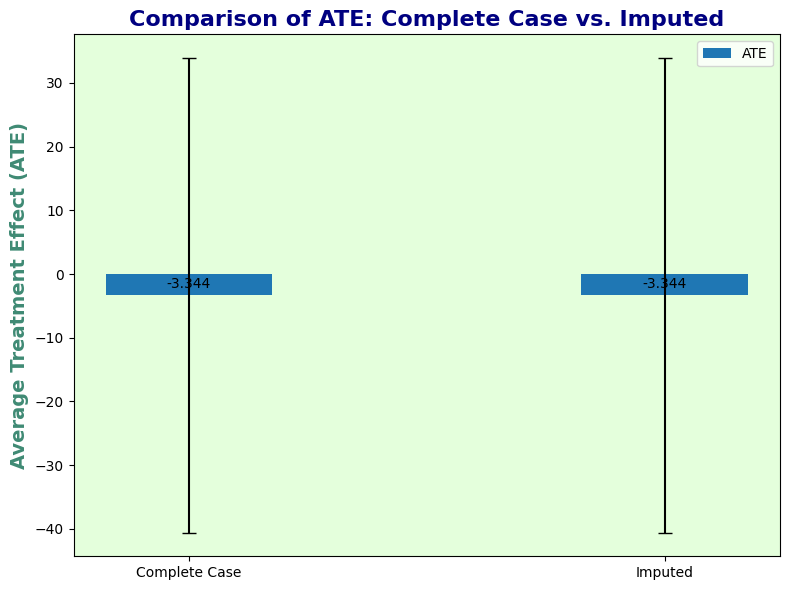

In [ ]:
# Visualization: Complete vs Imputed
ate_values = [ate_complete, ate_imputed]
ci_lower = [ate_interval_complete[0], ate_interval_imputed[0]]
ci_upper = [ate_interval_complete[1], ate_interval_imputed[1]]
labels = ['Complete Case', 'Imputed']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x, ate_values, width, label='ATE')
ax.errorbar(x, ate_values, yerr=[[ate_values[i] - ci_lower[i] for i in range(len(ate_values))],
                                  [ci_upper[i] - ate_values[i] for i in range(len(ate_values))]],
              fmt='none', ecolor='black', capsize=5)

ax.set_ylabel('Average Treatment Effect (ATE)', fontsize=14, fontweight='bold', color='#3f8a74')
ax.set_title('Comparison of ATE: Complete Case vs. Imputed', fontsize=16, fontweight='bold', color='navy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
fig.tight_layout()
plt.gca().set_facecolor('#e4ffdc')
plt.savefig('fig_complete_vs_imputed.png')
plt.show()

# 2. **Compare Causal Forest vs. TMLE vs. DML**

In [ ]:
print("\n--- 2. Compare Causal Forest vs. TMLE vs. DML ---")

# Split data
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42)

# Models
cf = CausalForestDML(random_state=42)
dml = DML(model_y=RandomForestRegressor(random_state=42),
          model_t=RandomForestRegressor(random_state=42),
          model_final=StatsModelsLinearRegression())

# Fit models
cf.fit(Y_train, T_train, X=X_train)
dml.fit(Y_train, T_train, X=X_train)

# ATE predictions
ate_cf = cf.ate(X_test).mean()
ate_dml = dml.ate(X_test).mean()

ate_interval_cf = cf.ate_interval(X_test)
ate_interval_dml = dml.ate_interval(X_test)


print(f"Causal Forest ATE: {ate_cf:.4f} CI: {ate_interval_cf[0]:.4f}, {ate_interval_cf[1]:.4f}")
print(f"DML ATE: {ate_dml:.4f} CI: {ate_interval_dml[0]:.4f}, {ate_interval_dml[1]:.4f}")



--- 2. Compare Causal Forest vs. TMLE vs. DML ---
Causal Forest ATE: -3.3445 CI: -40.5961, 33.9072
DML ATE: 0.5769 CI: -3.0250, 4.1787


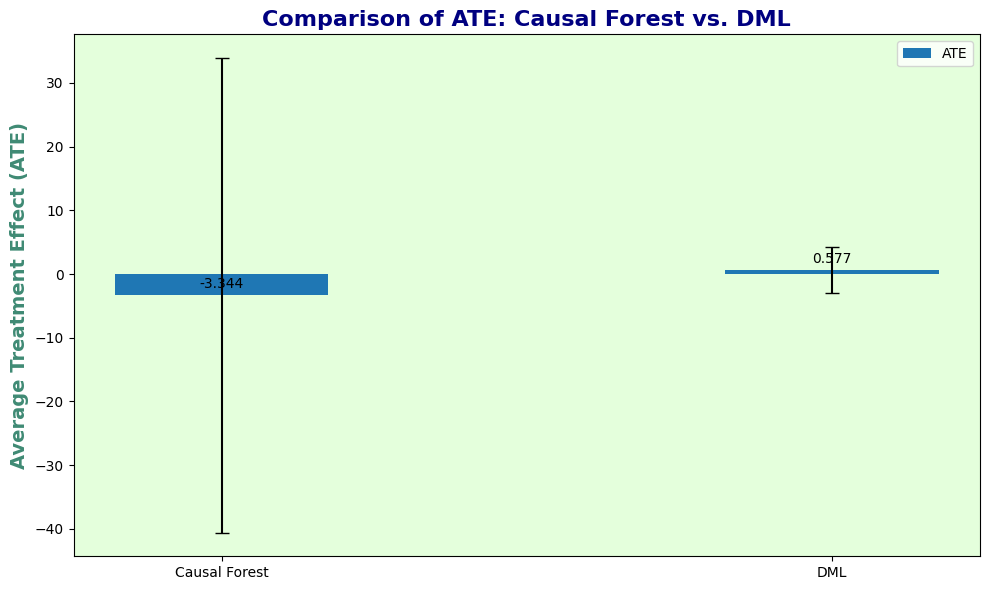

In [ ]:
# Visualization: Causal Forest vs. TMLE vs. DML
ate_values = [ate_cf, ate_dml]
ci_lower = [ate_interval_cf[0], ate_interval_dml[0]]
ci_upper = [ate_interval_cf[1], ate_interval_dml[1]]
labels = ['Causal Forest', 'DML']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, ate_values, width, label='ATE')
ax.errorbar(x, ate_values, yerr=[[ate_values[i] - ci_lower[i] for i in range(len(ate_values))],
                                  [ci_upper[i] - ate_values[i] for i in range(len(ate_values))]],
              fmt='none', ecolor='black', capsize=5)

ax.set_ylabel('Average Treatment Effect (ATE)', fontsize=14, fontweight='bold', color='#3f8a74')
ax.set_title('Comparison of ATE: Causal Forest vs. DML', fontsize=16, fontweight='bold', color='navy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
fig.tight_layout()
plt.gca().set_facecolor('#e4ffdc')
plt.savefig('fig_causal_methods_comparison.png')
plt.show()

# 3. **Exclude Small-Sample Countries and Rerun Key Analyses**

In [ ]:
print("\n--- 3. Exclude Small-Sample Countries and Rerun Key Analyses ---")

country_counts = df['cntry'].value_counts()
small_countries = country_counts[country_counts < 50].index  # Threshold of 50
df_large = df[~df['cntry'].isin(small_countries)].copy() #filtering the country

print(f"Original data size: {len(df)}")
print(f"Data size after excluding small-sample countries: {len(df_large)}")

# Define X, T, Y for the filtered data
X_large = df_large[feature_cols].copy()
T_large = df_large['BMI'].copy()
Y_large = df_large['CVD'].copy()

# Split data
X_train_large, X_test_large, Y_train_large, Y_test_large, T_train_large, T_test_large = train_test_split(
    X_large, Y_large, T_large, test_size=0.2, random_state=42
)

# Causal Forest DML (Large Countries Only)
cf_large = CausalForestDML(random_state=42)
cf_large.fit(Y_train_large, T_train_large, X=X_train_large)
ate_large = cf_large.ate(X_test_large).mean()
ate_interval_large = cf_large.ate_interval(X_test_large)

print(f"ATE (Large Countries): {ate_large:.4f} CI: {ate_interval_large[0]:.4f}, {ate_interval_large[1]:.4f}")


--- 3. Exclude Small-Sample Countries and Rerun Key Analyses ---
Original data size: 46162
Data size after excluding small-sample countries: 46162
ATE (Large Countries): -3.3445 CI: -40.5961, 33.9072


# 4. **Test Effect of Survey Weights: Weighted vs. Unweighted Results**

In [ ]:
print("\n--- 4. Test Effect of Survey Weights: Weighted vs. Unweighted Results ---")

# --- Unweighted ---
cf_unweighted = CausalForestDML(random_state=42)
cf_unweighted.fit(Y_train, T_train, X=X_train)
ate_unweighted = cf_unweighted.ate(X_test).mean()
ate_interval_unweighted = cf_unweighted.ate_interval(X_test)

# --- Weighted (using dweight) ---
cf_weighted = CausalForestDML(random_state=42)
weights_train = df.iloc[X_train.index]['dweight']
cf_weighted.fit(Y_train, T_train, X=X_train, sample_weight=weights_train)
ate_weighted = cf_weighted.ate(X_test).mean()
ate_interval_weighted = cf_weighted.ate_interval(X_test)

print(f"ATE (Unweighted): {ate_unweighted:.4f} CI: {ate_interval_unweighted[0]:.4f}, {ate_interval_unweighted[1]:.4f}")
print(f"ATE (Weighted): {ate_weighted:.4f} CI: {ate_interval_weighted[0]:.4f}, {ate_interval_weighted[1]:.4f}")



--- 4. Test Effect of Survey Weights: Weighted vs. Unweighted Results ---
ATE (Unweighted): -3.3445 CI: -40.5961, 33.9072
ATE (Weighted): -2.2753 CI: -35.2819, 30.7312


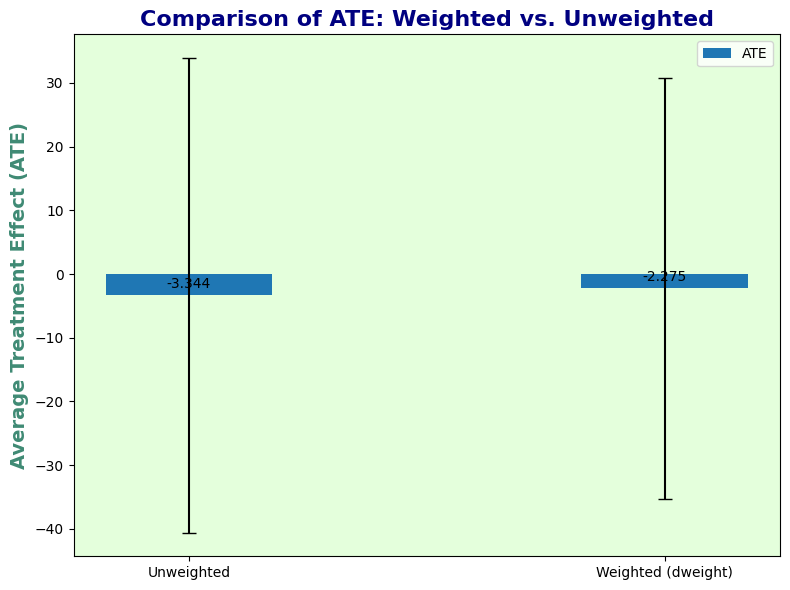

In [ ]:
# --- Visualization: Weighted vs. Unweighted Results ---
ate_values = [ate_unweighted, ate_weighted]
ci_lower = [ate_interval_unweighted[0], ate_interval_weighted[0]]
ci_upper = [ate_interval_unweighted[1], ate_interval_weighted[1]]
labels = ['Unweighted', 'Weighted (dweight)']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x, ate_values, width, label='ATE')
ax.errorbar(x, ate_values, yerr=[[ate_values[i] - ci_lower[i] for i in range(len(ate_values))],
                                  [ci_upper[i] - ate_values[i] for i in range(len(ate_values))]],
              fmt='none', ecolor='black', capsize=5)

ax.set_ylabel('Average Treatment Effect (ATE)', fontsize=14, fontweight='bold', color='#3f8a74')
ax.set_title('Comparison of ATE: Weighted vs. Unweighted', fontsize=16, fontweight='bold', color='navy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
fig.tight_layout()
plt.gca().set_facecolor('#e4ffdc')
plt.savefig('fig_weighted_vs_unweighted.png')
plt.show()

# 5. **Compute E-value**

In [ ]:
print("\n--- 5. Compute E-value ---")
# Use the ATE and CI from the unweighted analysis
ate = ate_unweighted
ate_lower = ate_interval_unweighted[0]
ate_upper = ate_interval_unweighted[1]

e_value, e_value_lower_ci = compute_e_value(ate, ate_lower, ate_upper)
print(f"E-value: {e_value:.4f}")
print(f"E-value Lower CI: {e_value_lower_ci:.4f}")



--- 5. Compute E-value ---
E-value: 6.1446
E-value Lower CI: 67.3106


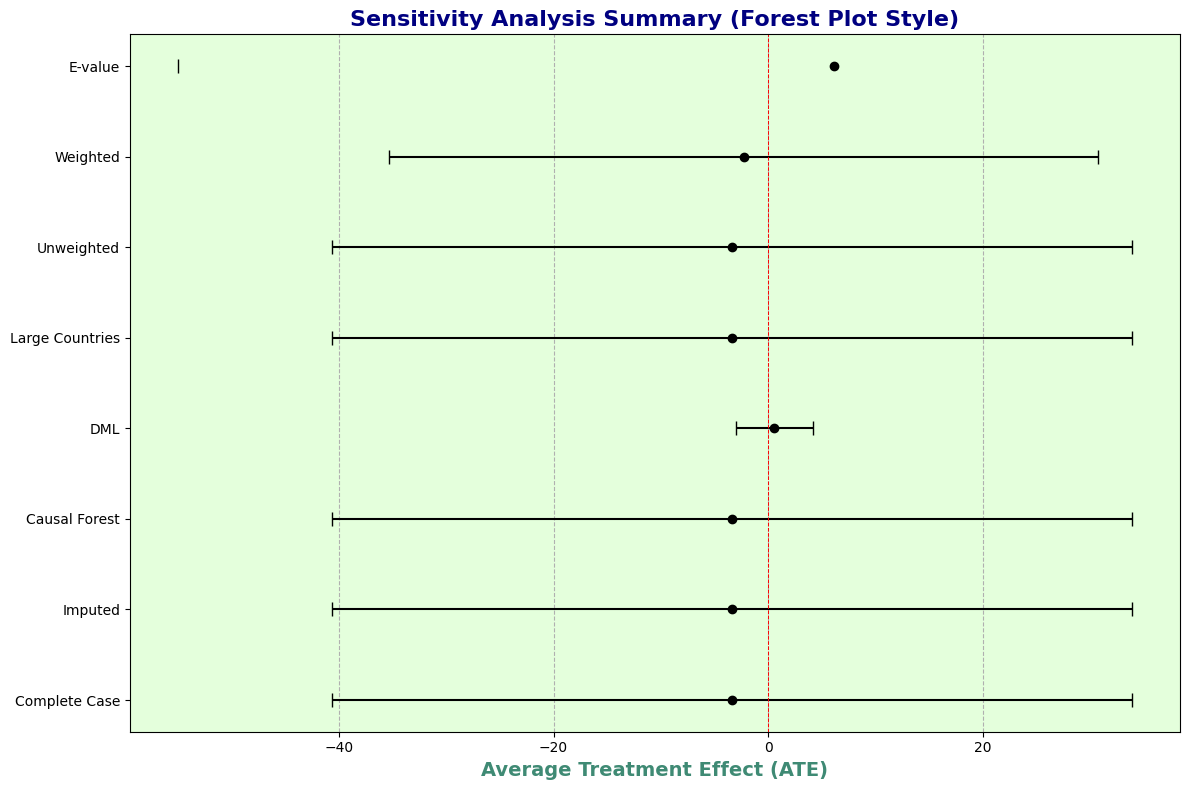


Sensitivity analysis complete. Results saved to tables/sensitivity_summary.csv and fig_sensitivity_plot.png


In [ ]:
# Save results to CSV and plot
sensitivity_results = {
    'Analysis': ['Complete Case', 'Imputed', 'Causal Forest', 'DML', 'Large Countries', 'Unweighted', 'Weighted', 'E-value'],
    'ATE': [ate_complete, ate_imputed, ate_cf, ate_dml, ate_large, ate_unweighted, ate_weighted, e_value],
    'CI_Lower': [ate_interval_complete[0], ate_interval_imputed[0], ate_interval_cf[0], ate_interval_dml[0], ate_interval_large[0], ate_interval_unweighted[0], ate_interval_weighted[0], e_value_lower_ci],
    'CI_Upper': [ate_interval_complete[1], ate_interval_imputed[1], ate_interval_cf[1], ate_interval_dml[1], ate_interval_large[1], ate_interval_unweighted[1], ate_interval_weighted[1], np.nan]
}

sensitivity_df = pd.DataFrame(sensitivity_results)

# Create the 'tables' directory if it doesn't exist
if not os.path.exists('tables'):
    os.makedirs('tables')


sensitivity_df.to_csv('tables/sensitivity_summary.csv', index=False)

# Consolidated Plot (Forest Plot Style)
plt.figure(figsize=(12, 8))
y_positions = range(len(sensitivity_df))
plt.errorbar(sensitivity_df['ATE'], y_positions,
             xerr=[(sensitivity_df['ATE'] - sensitivity_df['CI_Lower']).abs(),
                   (sensitivity_df['CI_Upper'] - sensitivity_df['ATE']).abs()],
             fmt='o', color='black', capsize=5)
plt.yticks(y_positions, sensitivity_df['Analysis'])
plt.xlabel('Average Treatment Effect (ATE)', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Sensitivity Analysis Summary (Forest Plot Style)', fontsize=16, fontweight='bold', color='navy')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.7)  # Line of No Effect
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.gca().set_facecolor('#e4ffdc')
plt.savefig('fig_sensitivity_plot.png')
plt.show()

print("\nSensitivity analysis complete. Results saved to tables/sensitivity_summary.csv and fig_sensitivity_plot.png")

In [ ]:
import pandas as pd
from IPython.display import display, HTML

def display_side_by_side(*args, titles=('',), justify="center"):
    """
    Displays pandas DataFrames side by side with optional titles.
    """
    html_str=''
    if len(titles)>0:
        html_str += "<table style='display: inline-table;'><tr>"
        for title in titles:
            html_str += "<td style='text-align:center'><h4 >{}</h4></td>".format(title)
        html_str += "</tr></table>"

    html_str += "<table style='border:none'>"
    html_str+="<tr style='border:none'>"
    for df in args:
        html_str+="<td style='vertical-align:top'>"
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="</td>"
    html_str+="</tr></table>"
    display(HTML(html_str))


# Paths to the CSV files
sensitivity_summary_path = '/content/tables/sensitivity_summary.csv'


# Read the CSV files into pandas DataFrames
try:
    sensitivity_summary_df = pd.read_csv(sensitivity_summary_path)

    # Display the DataFrames side by side with titles
    display_side_by_side(sensitivity_summary_df, titles=('Sensitivity Summary')) #Modified titles
except FileNotFoundError:
    print("One or more of the CSV files were not found.  Make sure the paths are correct and that the files exist.")
except Exception as e:
    print(f"An error occurred while reading or displaying the tables: {e}")

#Optionally Save the displayed output to a HTML file'
html_output = """
<!DOCTYPE html>
<html>
<head>
    <title> Tables</title>
</head>
<body>
"""

if 'sensitivity_summary_df' in locals():
    html_output += "<h2>Sensitivity_Summary</h2>"
    html_output += sensitivity_summary_df.to_html()

html_output += """
</body>
</html>
"""

output_file_path = 'tables_output.html'  # Define the output file path

try:
    with open(output_file_path, 'w') as f:
        f.write(html_output)
    print(f"Saved tables to {output_file_path}")
except Exception as e:
    print(f"Error saving HTML output: {e}")

Saved tables to tables_output.html


## Refer to Part2_Sensitivity Analysis and Method Comparison for continuation.